In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.cross_validation import train_test_split

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
np.random.seed(0)
#test and train data
dfTrain = pd.read_csv('train.csv')
dfTrain = dfTrain.sort_values(by=u'Category', ascending=1)
dfTest = pd.read_csv('test.csv')

In [3]:
#categories predicted for
labels = dfTrain[u'Category'].values
#drop data not used in model
dfTrain = dfTrain.drop([u'Category'], axis=1)
dfTrain = dfTrain.drop([u'Descript'], axis = 1)
dfTrain = dfTrain.drop([u'Resolution'], axis = 1)
#test id's for model
idTest = dfTest[u'Id']
dfTest = dfTest.drop([u'Id'], axis = 1)
piv_train = dfTrain.shape[0]

In [4]:
#combine testing and training sets for data wrangling
dfAll = pd.concat((dfTrain, dfTest), axis=0, ignore_index=True)

dateTime = np.vstack(dfAll.Dates.astype(str).apply(
    lambda x: list(map(float, x.replace('-',' ')
        .replace(':', ' ').split(' ')))).values)
#change time and date to a more continuous format
dfAll['year'] = dateTime[:,0]
dfAll['month'] = dateTime[:,1]
dfAll['day'] = dateTime[:,2]
dfAll['hour'] = dateTime[:,3]
dfAll['minute'] = dateTime[:,4]
dfAll['second'] = dateTime[:,5]

In [5]:
#remove date and time account created
dfAll = dfAll.drop(['Dates'], axis=1)
#change categorical variable to numerical, not using get_dummies
dfAll['Weekday'] = dfAll['DayOfWeek'].astype(
    'category').cat.codes.astype(float)
dfAll = dfAll.drop(['DayOfWeek'], axis = 1)
dfAll['PdDistrict'] = dfAll['PdDistrict'].astype(
    'category').cat.codes.astype(float)
dfAll['Address'] = dfAll['Address'].astype(
    'category').cat.codes.astype(float)

In [6]:
def set_param():
    # setup parameters for xgboost
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.4
    param['silent'] = 0
    param['nthread'] = 4
    param['num_class'] = len(np.unique(labels))
    param['eval_metric'] = 'merror'
    # Model complexity
    param['max_depth'] = 6 #set to 8
    param['min_child_weight'] = 1
    param['gamma'] = 0
    param['reg_alfa'] = 0.05
    param['subsample'] = 0.8
    param['colsample_bytree'] = 0.8 #set to 1
    # Imbalanced data
    param['max_delta_step'] = 1
    param['learning_rate'] = 0.1
    param['n_estimators'] = 30
    return param

In [7]:
#splitting training and test sets
vals = dfAll.values
X = vals[:piv_train]
X_test = vals[piv_train:]
le = LabelEncoder()
y = le.fit_transform(labels)

In [8]:
trainingSet = pd.DataFrame(X, columns=[list(dfAll.columns.values)])
trainingSet['Category'] = y
testingSet = pd.DataFrame(X_test,
    columns = [list(dfAll.columns.values)])
trainData, validateData = train_test_split(trainingSet,
                                        test_size = 0.2,
                                        random_state = 42)
trainX = trainData.drop('Category', 1)
trainY = trainData.Category
validateX = validateData.drop('Category', 1)
validateY = validateData.Category
#non splitted non matrix set, training data
cvSetX = trainingSet.drop('Category',1)
cvSetY = trainingSet.Category
#splitted set
dtrain = xgb.DMatrix(trainX, label = trainY)
dtest = xgb.DMatrix(validateX, label = validateY)
#non test-train-split set
drtrain = xgb.DMatrix(cvSetX, label = cvSetY)
dpred = xgb.DMatrix(testingSet)

In [9]:
from sklearn.grid_search import GridSearchCV
from time import time

//anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [13]:
t0 = time()
cv_params = {'n_estimators': [10,20,25,30]}
ind_params = {'max_depth':10, 'learning_rate': 0.1, 'min_child_weight': 1, 'seed': 0,
                'colsample_bytree': 0.8,
                'objective': 'multi:softprob', 'subsample':0.8,'nthread': 4
            }
# max depth = 10, learning_rate = 0.1

In [14]:
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params),
                            cv_params,
                             scoring = 'accuracy', cv = 2, n_jobs = -1)
print ("Param time:", round(time()-t0, 3), "s")
print('Cross Validating')
t0 = time()
optimized_GBM.fit(validateX, validateY)
print ("Training time:", round(time()-t0, 3), "s")
print (optimized_GBM.grid_scores_)

Param time: 1.258 s
Cross Validating


//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)


KeyboardInterrupt: 

In [11]:
#train xgb
model = xgb.train(param, trainMatrix);
yprob = model.predict(testMatrix).reshape(X_test.shape[0], num_class)
ids = np.linspace(0,X_test.shape[0],X_test.shape[0], dtype = int)

In [15]:
import operator
importances = model.get_fscore()
print(importances)

{'f8': 1642, 'f1': 2734, 'f0': 843, 'f3': 3189, 'f6': 713, 'f4': 1160, 'f5': 475, 'f2': 3084, 'f7': 1745, 'f10': 447}


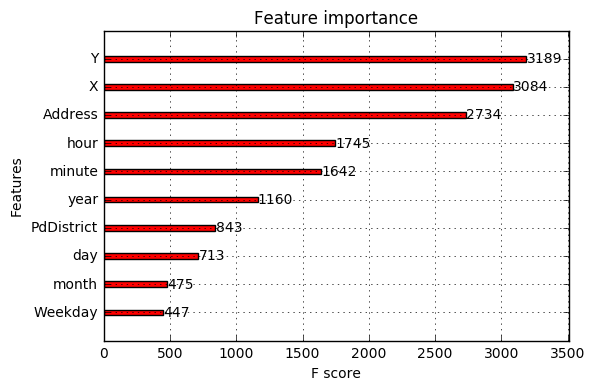

In [12]:
import matplotlib.pyplot as plt
# xgb.plot_importance(model)
# plt.show()
model.get_fscore()
mapper = {'f{0}'.format(i): v for i, v in enumerate(dfAll.columns)}
mapped = {mapper[k]: v for k, v in model.get_fscore().items()}
mapped
xgb.plot_importance(mapped, color='red')
plt.show()

In [17]:
#Generate submission
finalLabels = np.insert(np.unique(labels), 0, 'Id')
sub = pd.DataFrame(np.column_stack((ids, yprob)),
    columns=finalLabels)
sub.Id = sub.Id.astype(int)
sub.to_csv('subnew.csv',index=False)